In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from scipy import optimize as opt

%matplotlib inline

In [ ]:
class ODESolver:
    """
    Base class for ODE solvers.
    Subclasses of this class will implement a particular numerical
    scheme for solving a system of first-order ODEs of the form

        dY/dt = f(Y, t), Y(0)=Y0,

    where Y=Y(t) can be either a function of a single real-valued
    variable, or a vector of such functions.

    Note that the current implementation presumes a constant step
    size for the integration. This assumption will of course have
    to be relaxed if adaptive step size control is to be used.
    """

    def __init__(self, f, y0, dt):
        """
        :param f: The right-hand side function of the ODE (system).
        :param y0: The initial condition.
        :param dt: Constant step size.
        """
        # Trick: Ensure that f will return an array even if the
        # user returns a list
        self.f_ = lambda y, t: np.array(f(y, t), dtype='float')
        self.y0_ = y0
        self.dt_ = dt

        # Set simulation history to "None" before initializing
        self.t_ = None
        self.y_ = None

    def reset_model(self):
        """
        Resets the model before starting up a new simulation.
        """
        self.t_ = [0]
        self.y_ = [self.y0_]

    def solve(self, max_t, verbose=0):

        self.reset_model()

        no_steps = int(max_t / self.dt_)

        current_t = 0
        dt = self.dt_
        for _ in range(no_steps):
            self.advance(dt)
            current_t += dt
            if verbose:
                msg = 'Done computing solution at'
                msg += ' t={}.'.format(current_t)
                print(msg)
        return np.array(self.t_), np.array(self.y_)

    def advance(self, dt):
        err = "advance() cannot be called on base class ODESolver."
        err += " Must call on an instance of an ODESolver subclass!"
        raise NotImplementedError(err)

class ForwardEuler(ODESolver):

    def __init__(self, f, y0, dt):
        super().__init__(f, y0, dt)  # call superclass __init__ method

    def advance(self, dt):
        tn, yn = self.t_[-1], self.y_[-1]
        f = self.f_
        self.t_.append(tn+dt)
        self.y_.append(yn + dt * f(yn, tn))

    

    
class RungeKutta4(ODESolver):

    def __init__(self, f, y0, dt):
        super().__init__(f, y0, dt)  # call superclass __init__ method

    def advance(self, dt):
        tn, yn = self.t_[-1], self.y_[-1]
        f = self.f_
        self.t_.append(tn+dt)
        
        k_1 = dt*f(yn,tn)
        k_2 = dt*f(yn+ .5*k_1, tn + dt/2)
        k_3 = dt*f(yn + .5*k_2, tn + dt/2)
        k_4 = dt*f(yn + k_3, tn + dt)

        self.y_.append(yn + (1/6)*(k_1+2*k_2+2*k_3+ k_4))


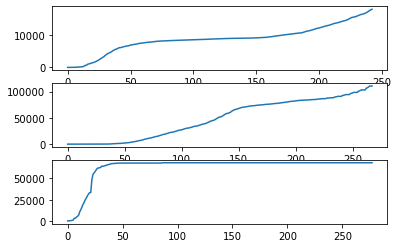

In [2]:
covidfile = pd.read_csv('data\corona_data.dat', sep ='\t')

Norway_data = covidfile.loc[covidfile['LOCATION'] == 'Norway']
Sweden_data = covidfile.loc[covidfile['LOCATION'] == 'Sweden']
Hubei_data = covidfile.loc[covidfile['LOCATION'] == 'Hubei']

covid_dta_fig, cov_ax = plt.subplots(3,1)
cov_ax[0].plot(Norway_data['ELAPSED_TIME_SINCE_OUTBREAK'],Norway_data['CONFIRMED'])
cov_ax[1].plot(Sweden_data['ELAPSED_TIME_SINCE_OUTBREAK'],Sweden_data['CONFIRMED'])
cov_ax[2].plot(Hubei_data['ELAPSED_TIME_SINCE_OUTBREAK'],Hubei_data['CONFIRMED'])

In [5]:
#Globals, setup, you know the drill

sigma = 1/5.1
gamma = 1/20
death_rate = 0.05

N = 58.5e6


def data_comb(Data, Orig_population):
    """function that retrieves relevant data from the file, given the Original population of the location the input data describes"""
    time_data = Data['ELAPSED_TIME_SINCE_OUTBREAK']
    S_data = Orig_population - Data['CONFIRMED'] -Data['RECOVERED'] - Data['DEATHS'] #Assume that the number of "Susceptible " is equall to population - confirmed cases e.g: no re-infection
    I_data = Data['CONFIRMED'] - Data['RECOVERED'] - Data['DEATHS']
    R_data = Data['RECOVERED']
    D_data = Data['DEATHS']

    #E data not directly obtainable from the other data, but derivative can be estimated (see gradient_function)
    return(time_data,S_data,I_data,R_data,D_data)

def data_gradient(combed_data):
    """Function that retrieves the "discrete" derivatives between the datapoints """    
    time_data = combed_data[0]
    dS_data = np.gradient(combed_data[1],time_data)
    dI_data = np.gradient(combed_data[2],time_data) 
    dR_data = np.gradient(combed_data[3],time_data)
    dD_data = np.gradient(combed_data[4], time_data)
    #
    dE_data = -dS_data - dI_data - sigma*combed_data[2] #Estm, dE from the other derivatives: assuming that the model is viable and sigma = 1/5.1
    # 
    return(time_data, dS_data,dE_data,dI_data,dR_data,dD_data)


def dSEIRD(data, beta0, lambda_par):
    """function that takes in "filtered/combed" data, and returns derivatives of the SEIRD model """
    t = np.array(data[0])
    beta = beta0*np.exp(-lambda_par*t)
    SEIRD_vec = data[1:]
    dS = (-beta/N)*SEIRD_vec[0]*SEIRD_vec[2]
    dE = (beta/N)*SEIRD_vec[0]*SEIRD_vec[2] - sigma*SEIRD_vec[1] 
    dI = sigma*SEIRD_vec[1] - gamma*SEIRD_vec[2]
    dR = (1- death_rate)*gamma*SEIRD_vec[2]
    dD = death_rate*gamma*SEIRD_vec[2]

    return np.array([dS,dE,dI,dR,dD]).flatten()                


data_combed = data_comb(Hubei_data, Orig_population = N)
derivative_data = data_gradient(data_combed)

popt = opt.curve_fit(dSEIRD,data_combed,np.array([derivative_data[1],derivative_data[2],derivative_data[3], derivative_data[4],derivative_data[5]]).flatten())

popt

(array([7.05674035, 0.10684342]),
 array([[4.63625700e+00, 1.79714378e-02],
        [1.79714378e-02, 7.50376772e-05]]))